# Быстрый градиентный метод и метод Ньютона

## На прошлой лекции

- Свойства градиентного спуска
- Скорость сходимости
- Число обусловленности
- Метод тяжёлого шарика
- Сравнение методов

## План на сегодня

- Быстрый градиентный метод
- Сходимость и сравнение с другими градиеннтными методами
- Метод Ньютона
- Скорость сходимости и сложность одной итерации

## Основные градиентные методы

- Градиентный спуск

$$ x_{k+1} = x_k - \alpha_k f'(x_k) $$

- Метод тяжёлого шарика

$$ x_{k+1} = x_k - \alpha_k f'(x_k) + \beta_k(x_k - x_{k-1}) $$

- Быстрый градиентный метод (Ю. Нестеров, 1983)

\begin{equation*}
\begin{split}
& y_0 = x_0 \\
& x_{k+1} = y_k - \alpha_k f'(y_k)\\
& y_{k+1} = x_{k+1} +  \beta_k(x_{k+1} - x_k)
\end{split}
\end{equation*}
        
- Простейший способ задания $\beta_k$ это $\beta_k = \frac{k}{k + 3}$

## Визуализация быстрого градиентного метода
<img src="nesterov_plot.png" width=600>


## Скорость сходимости

- Пусть $f$ выпукла с Липшицевым градиентом, а шаг $\alpha_k = \frac{1}{L}$. Тогда быстрый градиентный метод сходится как 

$$
f(x_k) - f^* \leq \frac{2L \|x_0 - x^*\|_2^2}{(k+1)^2}
$$ 

- Пусть $f$ выпукла с липшицевым градиентом и $\mu\mathbf{I} \preceq f''(x) \preceq L\mathbf{I}$. Тогда ускоренный метод Нестерова при шаге $\alpha_k = \frac{1}{L}$ сходится как

$$
f(x_k) - f^* \leq L\|x_k - x_0\|_2^2 \left(1 - \frac{1}{\sqrt{\kappa}} \right)^k,
$$

где $\kappa = \frac{L}{\mu}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def grad_descent(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    conv = [x]
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        x = x + alpha * h
        conv.append(x)
    return x, conv

def heavy_ball(f, grad, x0, num_iter, eps, alpha, beta):
    x = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(x)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = x + alpha * h
        else:
            x, prev_x = x + alpha * h + beta * (x - prev_x), x
            
        conv.append(x)
    return x, conv


def accelerated_gd(f, grad, x0, num_iter, eps, alpha):
    x = x0.copy()
    y = x0.copy()
    conv = [x]
    prev_x = None
    for i in range(num_iter):
        h = -grad(y)
        if np.linalg.norm(h) < eps:
            break
        if prev_x is None:
            prev_x = x.copy()
            x = y + alpha * h
        else:
            x, prev_x = y + alpha * h, x
        
        y = x + (i+1.) / (i+4.) * (x - prev_x)
            
        conv.append(x)
    return x, conv


In [38]:
np.random.seed(42)
# n = 4
n = 100
k = 10
A = np.random.randn(k, n)
A = A.T.dot(A) + 1e-1 * np.eye(n)

# Control ill-conditioned of A

x_true = np.random.randn(n)
b = A.dot(x_true)
f = lambda x: 0.5 * x.dot(A.dot(x)) - b.dot(x)
grad = lambda x: A.dot(x) - b
A_eigvals = np.linalg.eigvalsh(A)
L = np.max(A_eigvals)
mu = np.min(A_eigvals)
q = (L - mu) / (L + mu)
print(L, mu)
print("Condition number = {}".format(L / mu))
alpha_opt = 4 / (np.sqrt(L) + np.sqrt(mu))**2 
beta_opt = np.maximum((1 - np.sqrt(alpha_opt * L))**2, 
                      (1 - np.sqrt(alpha_opt * mu))**2)
print(alpha_opt, beta_opt)

172.58366035654436 0.09999999999996734
Condition number = 1725.8366035660072
0.022100387906078434 0.908187939460564


In [39]:
x0 = np.random.randn(n)
max_iter = 1000
tol = 1e-6

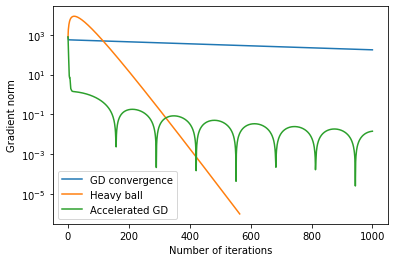

In [40]:
_, conv_gd = grad_descent(f, grad, x0, max_iter, tol, 2. / (L + mu))
_, conv_hb = heavy_ball(f, grad, x0, max_iter, tol, alpha_opt, beta_opt)
_, conv_acc = accelerated_gd(f, grad, x0, max_iter, tol, 1. / L)
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_gd], label="GD convergence")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_hb], label="Heavy ball")
plt.semilogy([np.linalg.norm(grad(x)) for x in conv_acc], label="Accelerated GD")
plt.xlabel("Number of iterations")
plt.ylabel("Gradient norm")
plt.legend()

## Выводы про ускоренный градиентный метод

- Обобщение метода тяжёлого шарика
- Можно показать. что метод является оптимальным для выпуклых функций среди методов вида

$$ x_{k+1} = x_0 + \texttt{span}\{f'(x_0), \ldots, f'(x_{k})\} $$

- На последней лекции обсудим, какие есть альтернативные варианты и к чему приводит их использование
- Этот метод удивительно хорошо работает и в невыпуклом случае для задач обучения глубоких нейросетей

## Метод Ньютона
Рассмотрим задачу

$$
\min\limits_{x\ \in \mathbb{R}^n} f(x).
$$

- Градиентный спуск $\equiv$ **линейная** аппроксимация $f$
- Метод Ньютона $\equiv$ **квадратичная** аппроксимация $f$:

$$
f(x + h) \approx f(x) + \langle f'(x), h \rangle + \frac{1}{2}h^{\top}f''(x)h \to \min_{h}
$$

Из необходимого условия минимума:

$$
f'(x) + f''(x) h = 0, \qquad h^* = -(f''(x))^{-1} f'(x)
$$


### Является ли найденное направление направлением убывания?

Проверим знак скалярного произведения $\langle f'(x), h^* \rangle$.

$$
\langle f'(x), h^* \rangle = -(f')^{\top}(x) (f''(x))^{-1} f'(x) < 0 \Leftarrow f''(x) \succ 0
$$

## Метод Ньютона

- Классический метод Ньютона: $\alpha_k \equiv 1$
- Демпфированный метод Ньютона: $\alpha_k$ выбирается на каждой итерации по заданному правилу

```python
def NewtonMethod(f, x0, epsilon, **kwargs):
    
    x = x0
    
    while True:
        
        h = ComputeNewtonStep(x, f, **kwargs)
        
        if StopCriterion(x, f, h, **kwargs) < epsilon:
            
            break
            
        alpha = SelectStepSize(x, h, f, **kwargs)
            
        x = x + alpha * h
            
    return x

```

## Теорема сходимости (Ю. Е. Нестеров Введение в выпуклую оптимизацию, $\S$ 1.2)

**Теорема.** Пусть функция $f(x)$
- дважды дифференцируема и её гессиан удовлетворяет условию Липшица с константой $M$
- существует точка локального минимума с положительно определённым гессианом

$$
f''(x^*) \succeq l\mathbf{I}, \; l > 0
$$

- начальная точка $x_0$ достаточно близка к точке минимума, в частности

$$
\|x_0 - x^*\|_2 \leq \frac{2l}{3M}
$$

Тогда метод Ньютона сходится **квадратично**:

$$
\|x_{k+1} - x^* \|_2 \leq \dfrac{M\|x_k - x^*\|^2_2}{2 (l - M\|x_k - x^*\|_2)}
$$

## Метод Ньютона для поиска корня системы нелинейных уравнений

- Если необходимо решить систему нелинейных уравнений

$$ g(x) = 0, $$

 то метод Ньютона записывается как 
 
 $$ x_{k+1} = x_k - g'(x_k)^{-1} g(x_k) $$
 
- Если рассмотреть необходимое условие экстремума $f'(x) = 0$ как такую систему, то метод Ньютона для её решения совпадёт с методом Ньютона для минимизации исходной функции $f$

### Пример

Применим метод Ньютона для поиска корня следующей функции

$$
\varphi(t) = \dfrac{t}{\sqrt{1+t^2}}
$$

и определим область сходимости.

Возможные варианты:
- сходится
- расходится
- осциллирует

In [12]:
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

def f(x):
    return x / (jnp.sqrt(1 + x**2))

def newton_solve_system(f, jacf, x0, num_iter):
    x = x0
    for i in range(num_iter):
        x = x - jnp.linalg.solve(jacf(x), f(x))
        print(f(x))

x0 = jnp.array([-0.9])
# x0 = jnp.array([-1])
# x0 = jnp.array([-1.1])
num_iter = 10
newton_solve_system(f, jax.jacobian(f), x0, num_iter)

[0.58908423]
[-0.3612566]
[0.05805167]
[-0.00019663]
[7.60203378e-12]
[0.]
[0.]
[0.]
[0.]
[0.]


## Вычислительная сложность

Узкие места метода Ньютона:

- формирование и хранение гессиана - квадратичная сложность по памяти
- решение систем линейных уравнений

$$
f''(x_k)h = -f'(x_k)
$$

кубическая (!) сложность по времени



## Использование структуры функции для ускорения решения

- Разделение переменных - диагональный гессиан
- Разделение переменных + функция от маломерного аргумента - гессиан имеет структуру диагональная матрица + матрица малого ранга

## Выводы про метод Ньютона

- Высокая скорость сходимость
- Использует гессиан
- Высокая стоимость одной итерации